In [1]:
import pandas as pd
import numpy as np

# Order_Date: 주문한 날짜
# Time: 주문 시간
# Aging: 주문한 이후의 경과 시간
# Customer_Id: 고객의 고유 식별자
# Gender: 고객의 성별
# Device_Type: 주문을 한 장치 유형
# Customer_Login_type: 고객의 로그인 유형
# Product_Category: 제품 카테고리
# Product: 제품
# Sales: 판매액
# Quantity: 주문 수량
# Discount: 할인
# Profit: 이익
# Shipping_Cost: 배송 비용
# Order_Priority: 주문 우선순위
# Payment_method: 결제 방법

customer = pd.read_csv('./datasets/customer.csv')
customer

,Order_Date,Time,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method
0,2018-01-02,10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,1.0,0.3,46.0,4.6,Medium,credit_card
1,2018-07-24,20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,1.0,0.3,112.0,11.2,Medium,credit_card
2,2018-11-08,08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,5.0,0.1,31.2,3.1,Critical,credit_card
3,2018-04-18,19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,1.0,0.3,26.2,2.6,High,credit_card
4,2018-08-13,21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,1.0,0.3,160.0,16.0,Critical,credit_card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,2018-02-28,22:59:50,6.0,78489,Female,Mobile,Member,Home & Furniture,Shoe Rack,124.0,4.0,0.3,19.2,1.9,Medium,money_order
51286,2018-02-28,13:19:25,2.0,91941,Female,Mobile,Member,Home & Furniture,Umbrellas,70.0,5.0,0.2,14.0,1.4,Medium,credit_card
51287,2018-02-28,10:25:07,6.0,63313,Male,Web,Member,Home & Furniture,Dinner Crockery,133.0,1.0,0.3,39.7,4.0,Medium,credit_card
51288,2018-02-28,10:50:08,7.0,86485,Male,Web,Member,Home & Furniture,Sofa Covers,216.0,1.0,0.2,131.7,13.2,Medium,credit_card


In [2]:
customer.drop(['Time','Aging', 'Product','Discount', 'Profit', 'Shipping_Cost', 'Order_Priority'  ], axis=1, inplace=True)
customer = customer.dropna()
customer.columns = ['Date', 'CustomerID' ,'Gender' ,'in', 'type' ,'category', 'price','Quantity','payment'  ]

In [3]:
import pandas as pd

# 데이터프레임 예시
customer = pd.DataFrame(customer)

# 'Date' 열을 datetime 형식으로 변환
customer['Date'] = pd.to_datetime(customer['Date'])

# 송장번호 최대 날짜 구하기
InvoiceDate_max = customer['Date'].max()

# InvoiceDate 최대 날짜로부터 지난 구매 날짜로 변경하기 (Recency)
customer['Recency'] = (InvoiceDate_max - customer['Date']).dt.days

# 'Date' 열 삭제
customer.drop(columns=['Date'], inplace=True)

# 'ordercount' 열을 추가하고 초기값을 0으로 설정합니다.
customer['ordercount'] = 0

# 'CustomerID' 열의 중복 여부를 확인합니다.
is_duplicate = customer['CustomerID'].duplicated()

# 중복된 값에 대해 ordercount를 중복된 횟수만큼 증가시킵니다.
duplicated_counts = customer['CustomerID'].value_counts()
for customer_id, count in duplicated_counts.items():
    if count > 1:
        customer.loc[customer['CustomerID'] == customer_id, 'ordercount'] += count - 1
customer_unique = customer.drop_duplicates(subset='CustomerID', keep='first')

# 'Recency' 값이 가장 작은 행을 선택합니다.
customer_unique = customer_unique.sort_values(by='Recency')
customer = customer.sort_values(by=['CustomerID', 'Recency']).drop_duplicates(subset='CustomerID')



In [4]:
customer['totalprice'] = customer['price'] * customer['Quantity']


In [5]:
rfm = customer[['Recency', 'Quantity', 'totalprice']].copy()

# 새로운 데이터프레임의 열 이름 변경
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rfm[['Recency', 'Frequency', 'Monetary']] = \
                                    scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
# 최근일 수록 숫자가 더 작게 나오기 때문에, 1을 빼준 값으로 점수를 계산한다.
rfm['Recency'] = 1 - rfm['Recency']

In [7]:
customer['TotalScore'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']

In [8]:
import numpy as np

l1, l2, l3, l4 = np.percentile(customer['TotalScore'], [25, 45, 65, 85])
print(l1, l2, l3, l4)

0.7744600709417322 1.0411366975197558 1.485307348150965 2.032020096384778


In [9]:
def get_level(x):
    if x <= l1:
        return 5
    if x > l1 and x <= l2:
        return 4
    if x > l2 and x <= l3:
        return 3
    if x > l3 and x <= l4:
        return 2
    return 1

In [10]:
customer['Level'] = customer['TotalScore'].apply(get_level)
customer['Level'] = customer['Level'].replace([5, 4, 3, 2, 1], ['Bronze', 'Silver', 'Gold', 'Diamond', 'VIP'])
print(customer['Level'].value_counts())
customer

Level
Bronze     9750
Diamond    7799
Gold       7798
Silver     7798
VIP        5849
Name: count, dtype: int64


,CustomerID,Gender,in,type,category,price,Quantity,payment,Recency,ordercount,totalprice,TotalScore,Level
4274,10000,Male,Web,Member,Auto & Accessories,231.0,1.0,credit_card,24,1,231.0,1.096579,Gold
17993,10002,Male,Web,Member,Electronic,149.0,2.0,credit_card,132,0,298.0,1.104112,Gold
14911,10004,Male,Web,Guest,Fashion,85.0,4.0,credit_card,144,0,340.0,1.605565,Diamond
19851,10006,Male,Web,Member,Electronic,220.0,1.0,credit_card,144,1,220.0,0.756962,Bronze
22697,10013,Male,Web,Member,Fashion,159.0,1.0,credit_card,227,0,159.0,0.478189,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29918,99990,Female,Web,Member,Home & Furniture,78.0,3.0,credit_card,8,0,234.0,1.643122,Diamond
42519,99991,Male,Web,Guest,Fashion,85.0,1.0,credit_card,54,0,85.0,0.893968,Silver
33949,99992,Female,Web,Member,Home & Furniture,124.0,1.0,credit_card,214,0,124.0,0.485242,Bronze
39209,99993,Male,Web,Member,Fashion,122.0,3.0,money_order,174,0,366.0,1.294285,Gold


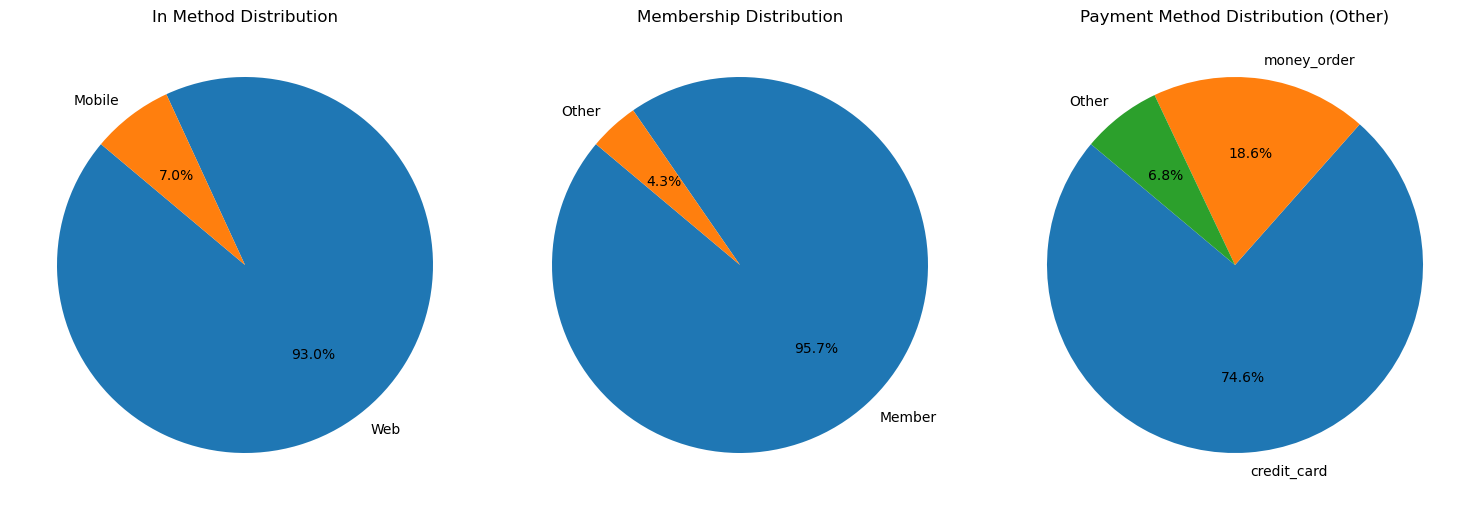

In [11]:
import matplotlib.pyplot as plt
payment_counts = customer['in'].value_counts()
modified_customer = customer.copy()
modified_customer.loc[modified_customer['type'] != 'Member', 'type'] = 'Other'

# 수정된 데이터프레임에서 'type' 열의 값들의 빈도를 계산합니다.
modified_payment_counts = modified_customer['type'].value_counts()


customer['payment'] = customer['payment'].apply(lambda x: 'Other' if x not in ['credit_card', 'money_order'] else x)

# 'payment' 열의 값들의 빈도를 계산합니다.
payment_counts = customer['payment'].value_counts()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
in_counts = customer['in'].value_counts()
plt.pie(in_counts, labels=in_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('In Method Distribution')

# 두 번째 subplot: 'type' 열의 값들의 빈도를 파이 그래프로 표시
plt.subplot(1, 3, 2)
modified_customer = customer.copy()
modified_customer.loc[modified_customer['type'] != 'Member', 'type'] = 'Other'
modified_payment_counts = modified_customer['type'].value_counts()
plt.pie(modified_payment_counts, labels=modified_payment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Membership Distribution')

# 세 번째 subplot: 'payment' 열의 값들을 조건에 따라 그룹화하여 파이 그래프로 표시
plt.subplot(1, 3, 3)
customer['payment'] = customer['payment'].apply(lambda x: 'Other' if x not in ['credit_card', 'money_order'] else x)
payment_counts = customer['payment'].value_counts()
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Payment Method Distribution (Other)')

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

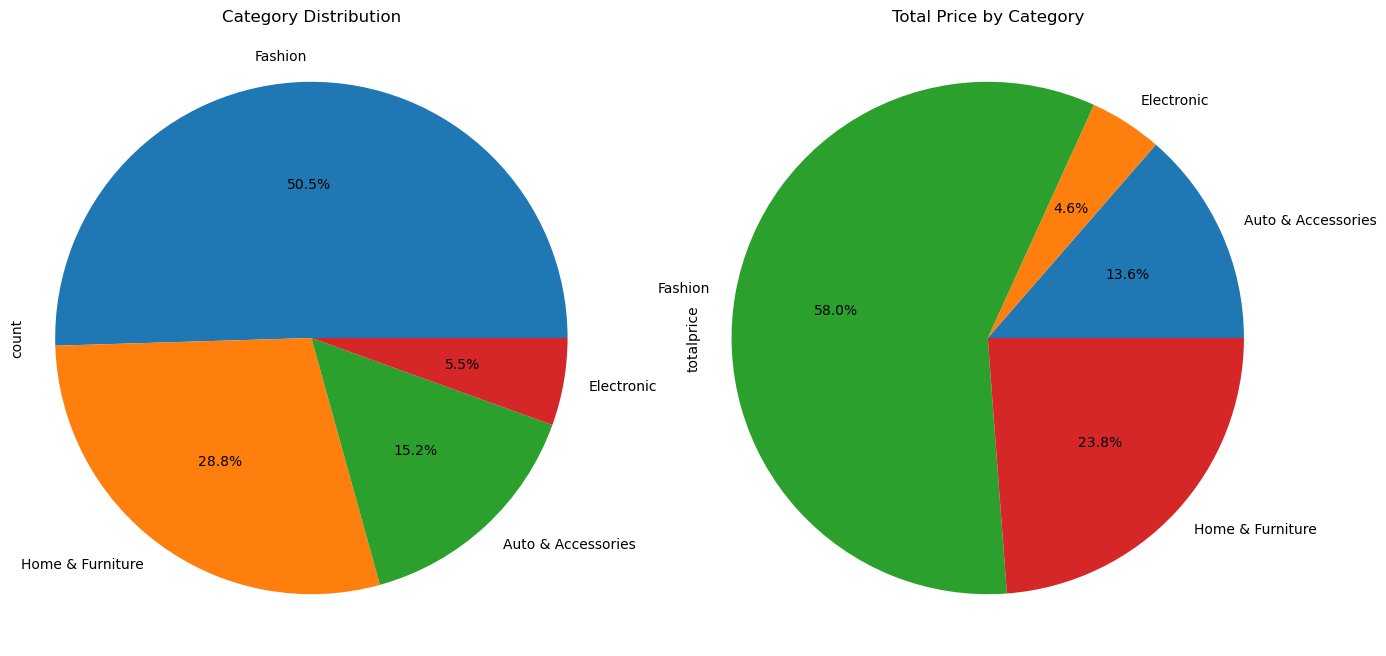

In [12]:
import matplotlib.pyplot as plt

# 왼쪽: 'category' 열의 값 분포 확인
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
customer['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Category Distribution')
plt.axis('equal')

# 오른쪽: category에 따른 totalprice의 합 원그래프로 시각화
plt.subplot(1, 2, 2)
total_price_by_category = customer.groupby('category')['totalprice'].sum()
total_price_by_category.plot(kind='pie', autopct='%1.1f%%')
plt.title('Total Price by Category')
plt.axis('equal')

plt.show()


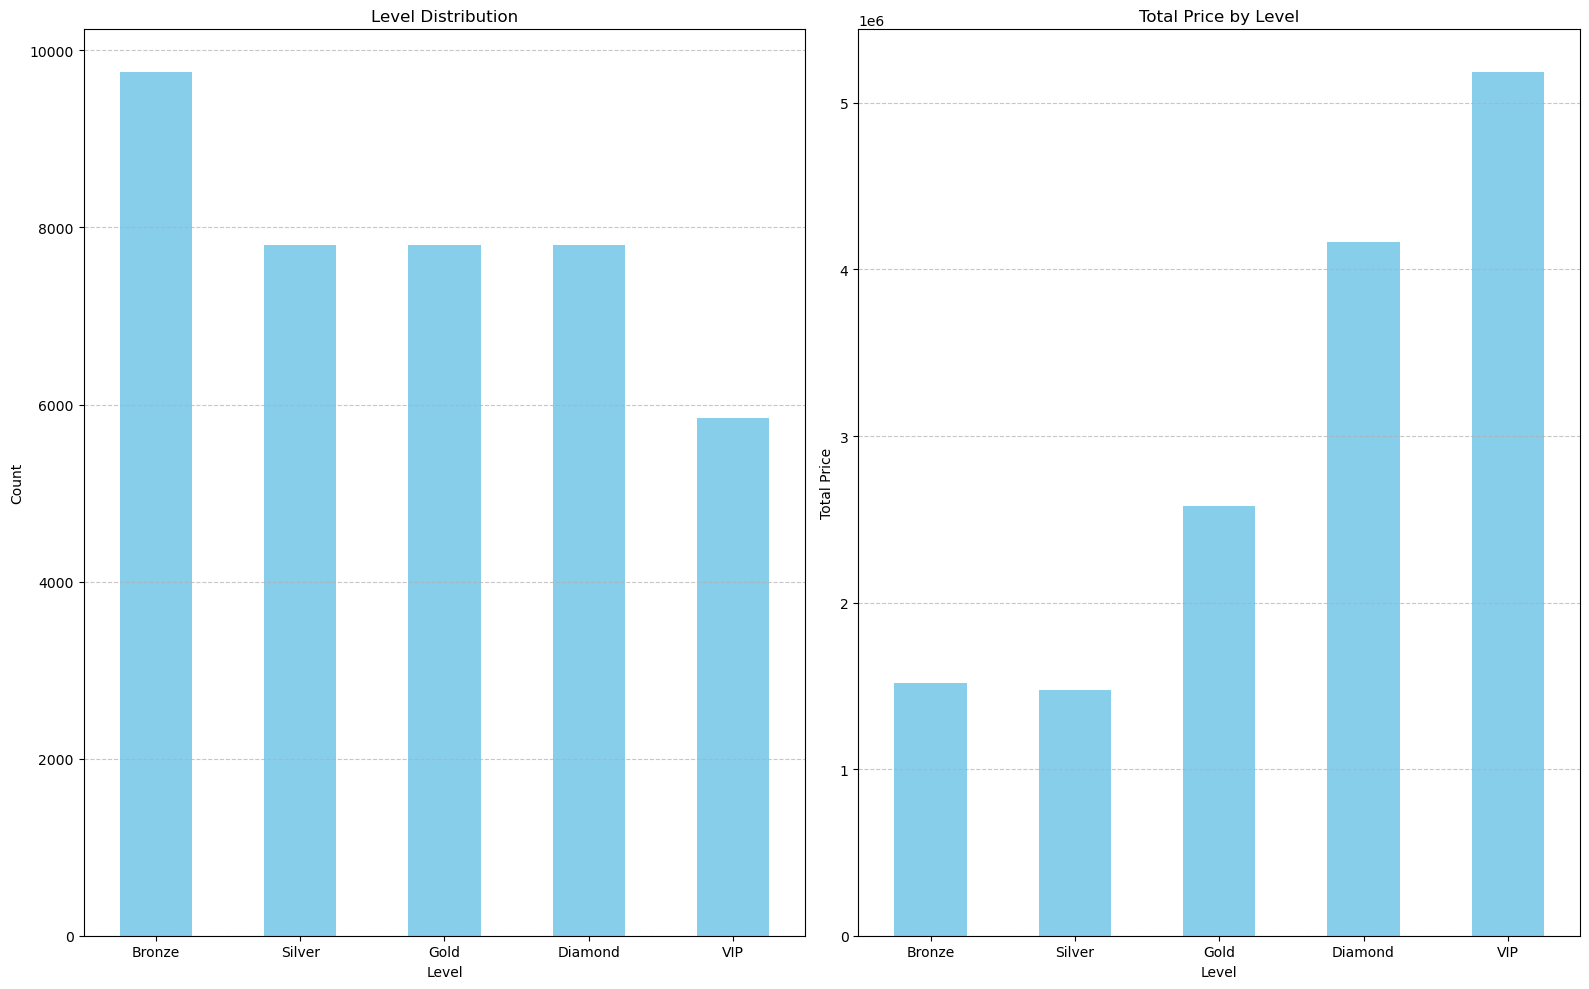

In [13]:
import matplotlib.pyplot as plt

# 순서를 정의합니다.
level_order = ['Bronze', 'Silver', 'Gold', 'Diamond', 'VIP']

# 왼쪽: 'Level' 열의 값들의 빈도를 바 그래프로 표시합니다.
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
level_counts = customer['Level'].value_counts()
level_counts.loc[level_order].plot(kind='bar', color='skyblue')
plt.title('Level Distribution')
plt.xlabel('Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 오른쪽: 각 등급별 totalprice의 합을 바 그래프로 표시합니다.
plt.subplot(1, 2, 2)
total_price_by_level = customer.groupby('Level')['totalprice'].sum()
total_price_by_level.loc[level_order].plot(kind='bar', color='skyblue')
plt.title('Total Price by Level')
plt.xlabel('Level')
plt.ylabel('Total Price')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


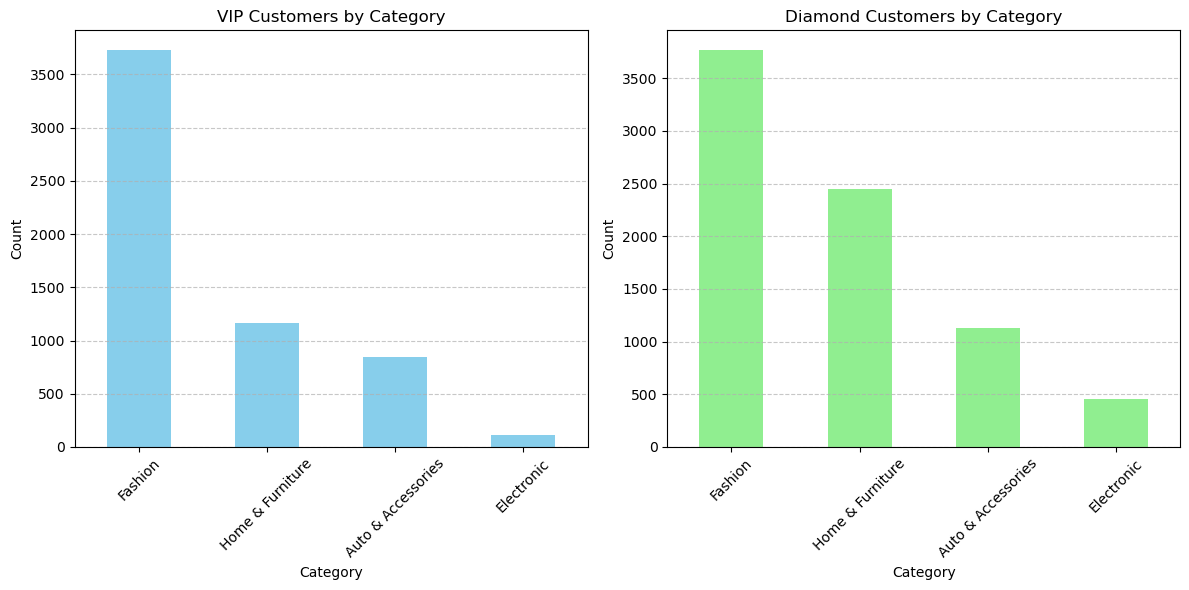

In [14]:
import matplotlib.pyplot as plt

# VIP 레벨의 고객들 중에서 category 값의 빈도를 계산합니다.
vip_customers = customer[customer['Level'] == 'VIP']
vip_category_counts = vip_customers['category'].value_counts()

# Diamond 레벨의 고객들 중에서 category 값의 빈도를 계산합니다.
diamond_customers = customer[customer['Level'] == 'Diamond']
diamond_category_counts = diamond_customers['category'].value_counts()

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))

# VIP 레벨의 고객들의 category 값의 빈도를 나타내는 그래프
plt.subplot(1, 2, 1)
vip_category_counts.plot(kind='bar', color='skyblue')
plt.title('VIP Customers by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Diamond 레벨의 고객들의 category 값의 빈도를 나타내는 그래프
plt.subplot(1, 2, 2)
diamond_category_counts.plot(kind='bar', color='lightgreen')
plt.title('Diamond Customers by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


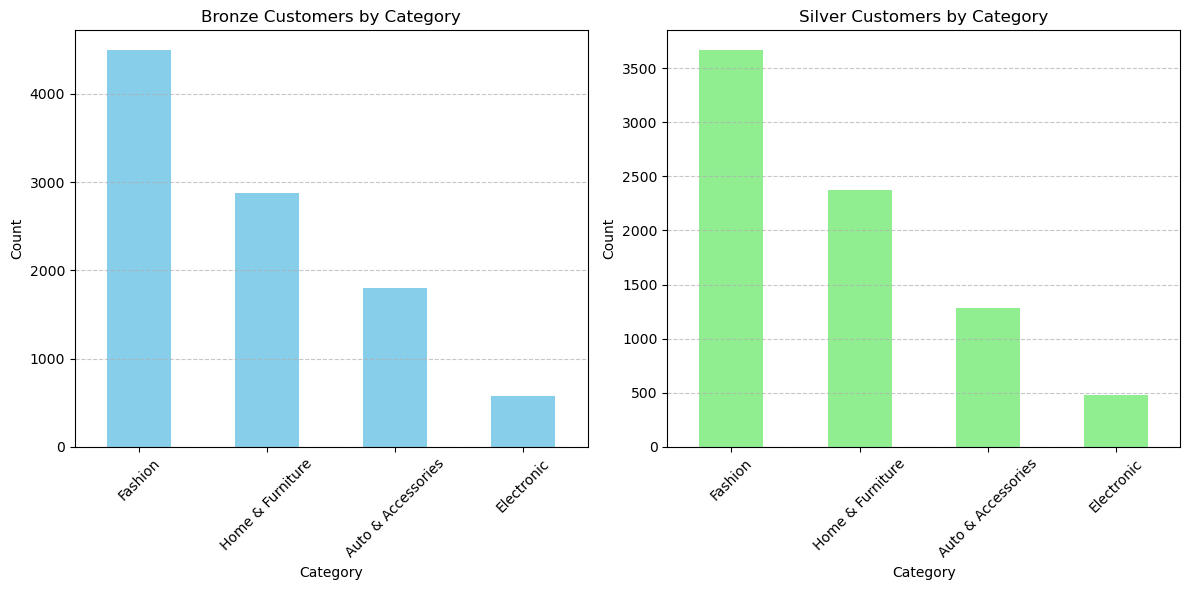

In [15]:
import matplotlib.pyplot as plt

# VIP 레벨의 고객들 중에서 category 값의 빈도를 계산합니다.
vip_customers = customer[customer['Level'] == 'Bronze']
vip_category_counts = vip_customers['category'].value_counts()

# Diamond 레벨의 고객들 중에서 category 값의 빈도를 계산합니다.
diamond_customers = customer[customer['Level'] == 'Silver']
diamond_category_counts = diamond_customers['category'].value_counts()

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))

# VIP 레벨의 고객들의 category 값의 빈도를 나타내는 그래프
plt.subplot(1, 2, 1)
vip_category_counts.plot(kind='bar', color='skyblue')
plt.title('Bronze Customers by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Diamond 레벨의 고객들의 category 값의 빈도를 나타내는 그래프
plt.subplot(1, 2, 2)
diamond_category_counts.plot(kind='bar', color='lightgreen')
plt.title('Silver Customers by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


category
Auto & Accessories    146.383978
Electronic            145.460000
Fashion               169.639250
Home & Furniture      127.864894
Name: price, dtype: float64


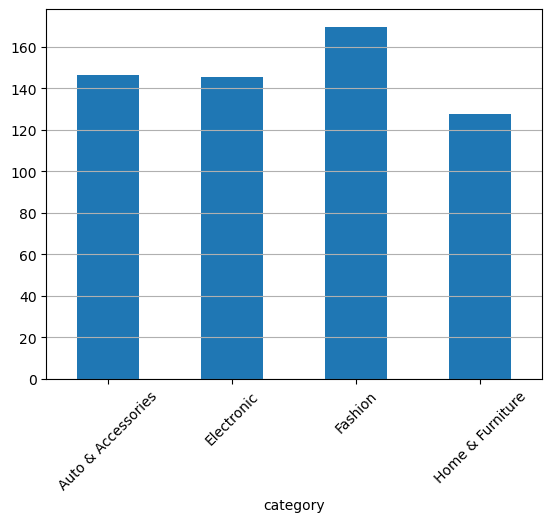

In [16]:
# 카테고리별 가격의 평균을 계산합니다.
average_price_by_category = customer.groupby('category')['price'].mean()

# 결과를 출력합니다.
print(average_price_by_category)
average_price_by_category.plot(kind='bar')

plt.xticks(rotation=45)  # x 축 레이블을 45도 회전하여 가성을 높임
plt.grid(axis='y')  # y 축에 그리드 추가
plt.show()

<Figure size 800x600 with 0 Axes>

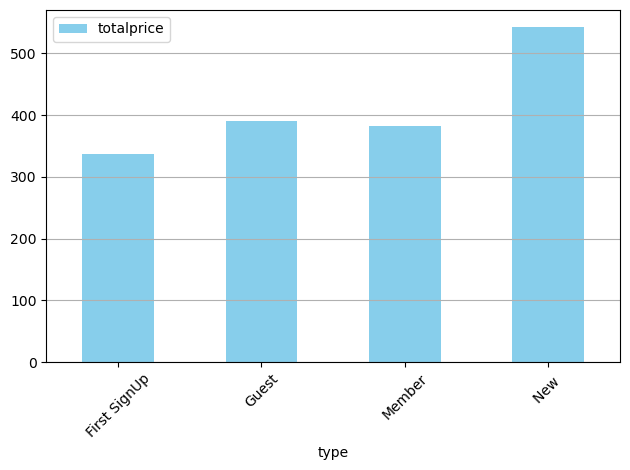

In [17]:
# 'in' 칼럼을 그룹으로 묶어서 'totalprice'의 평균 계산
average_totalprice_in = customer.groupby('type')[['totalprice']].mean()
import matplotlib.pyplot as plt

# 그래프를 그리기 위해 설정
plt.figure(figsize=(8, 6))

# 그래프 그리기
average_totalprice_in.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)  # x 축 레이블을 45도 회전하여 가독성을 높임
plt.grid(axis='y')  # y 축에 그리드 추가
plt.tight_layout()

# 그래프 출력
plt.show()


### 마케팅 전략

- 신규고객들을 유입할 수 있는 마케팅을 진행하여 새로운 고객을 지속적으로 모집할 수 있어야한다.
- 신규고객들을 대상들을 대상으로 지속적으로 쇼핑몰에 남을 수 있도록 할인혜택을 제공한다.
  
- 의류 카테고리가 가격대가 있지만 전체적으로 사랑받는중 고가의 물품을 위주로 Diamond, VIP등급 고객들대상으로 프리미엄 제품 제공
- 낮은 등급에서 인테리물품, 차량소품이 많이 팔리고있다. 저가형에 간단한 인테리어물품 위주로 물품을 준비하여 고객들을 지속적으로 이끌어야한다.